INCOMPLETE: There is a mismatch between the implementation from the paper and package results.

This notebook implements a low frequency approximation for MEEM. The approximation uses the first radial eigenfunction(s) for each region while the vertical eigenfunction is constant (no z-dependence). It is "depth-averaged", and every A-matrix/b-vector equation is divided by the integrated depth. The general form is shown to match the two-region form given in Chau 2012. Damping converges to a finite value while added mass goes to infinite.

Previous results, now suspect: Comparisons between the outputs generated in this file and via the full MEEM implementations show that the convergence between the approximation and the full version is very slow, and configuration dependent. The conclusion is that this should not be added to the final package.

In [16]:
#import block
import numpy as np
from scipy.special import hankel1 as besselh
import scipy.linalg as linalg
from numpy import log, pi, sqrt
import matplotlib.pyplot as plt
from openflash import *

In [ ]:
# Computing with package MEEM
def make_flat_geometry(h, d, a, heaving, NMK):
  bodies = [SteppedBody(a=np.array([a[i]]), d=np.array([d[i]]), slant_angle=np.array([0.0]), heaving=heaving[i]) for i in range(len(a))]
  return BasicRegionGeometry(body_arrangement=ConcentricBodyGroup(bodies), h=h, NMK=NMK)

def make_problem_and_engine(h, d, a, heaving, m0s, NMK):
  frequencies = np.array([omega(m0, h, g) for m0 in m0s])
  problem = MEEMProblem(make_flat_geometry(h, d, a, heaving, NMK))
  problem.set_frequencies(frequencies)
  engine = MEEMEngine(problem_list=[problem])
  return problem, engine

def solve_true_MEEM(h, d, a, heaving, m0s, NMK, mode_index):
  problem, engine = make_problem_and_engine(h, d, a, heaving, m0s, NMK)
  nondim_ams, nondim_dps = [], []
  for m0 in m0s:
    X = engine.solve_linear_system_multi(problem, m0)
    hydros = engine.compute_hydrodynamic_coefficients(problem, X, m0)
    nondim_ams.append(hydros[mode_index]["nondim_real"] / (h**3))
    nondim_dps.append(hydros[mode_index]["nondim_imag"] / (h**3))
  return nondim_ams, nondim_dps

In [2]:
# constants block
g = 9.81
rho = 1023

In [ ]:
def particular_potential(h, d, r, n, heaving):
    if n >= len(d): # free surface region
        return 0
    if heaving[n]:
        return - (r**2)/(4 * (h - d[n]))
    else:
        return 0

def diff_particular_potential_total(a, r, n, heaving):
    if n >= len(a): # free surface region
        return 0
    if heaving[n]:
        return - r/2
    else:
        return 0

def b_potential_entry(h, d, a, n, heaving):
    return - particular_potential(h, d, a[n], n, heaving) + particular_potential(h, d, a[n], n + 1, heaving)

def b_velocity_entry(a, n, heaving):
    return - diff_particular_potential_total(a, a[n], n, heaving) + diff_particular_potential_total(a, a[n], n + 1, heaving)
    
# sets potential equation for nth boundary into the A matrix
def potential_row(a, A, n, m0, bds):
    if n == 0:
        if bds == 1: # single cylinder
            A[0][0] = 1
            A[0][1] = - besselh(0, m0 * a[0])
        else:
            A[0][0] = 1
            A[0][1] = - 1
            A[0][2] = - log(a[0])
    elif n == bds - 1:
        A[n][2*n - 1] = 1
        A[n][2*n] = log(a[n])
        A[n][2*n + 1] = - besselh(0, m0 * a[n])
    else:
        A[n][2*n - 1] = 1
        A[n][2*n] = log(a[n])
        A[n][2*n + 1] = - 1
        A[n][2*n + 2] = - log(a[n])

def velocity_row(h, d, a, A, n, m0, bds):
    if n == 0:
        if bds == 1: # single cylinder
            A[bds][0] = 0
            A[bds][1] = h * m0 * besselh(1, m0 * a[0])
        else:
            A[bds][0] = 0
            A[bds][1] = 0
            A[bds][2] = - 1/a[0] * (h - d[1])
    elif n == bds - 1:
        A[bds + n][2*n - 1] = 0
        A[bds + n][2*n] = 1/a[n] * (h - d[n])
        A[bds + n][2*n + 1] = h * m0 * besselh(1, m0 * a[n])
    else:
        A[bds + n][2*n - 1] = 0
        A[bds + n][2*n] = 1/a[n] * (h - d[n])
        A[bds + n][2*n + 1] = 0
        A[bds + n][2*n + 2] = - 1/a[n] * (h - d[n + 1])

def build_A(h, d, a, m0):
    bds = len(a)
    A = np.zeros((2 * bds, 2 * bds), dtype = complex)
    for n in range(bds):
        potential_row(a, A, n, m0, bds)
        velocity_row(h, d, a, A, n, m0, bds)
    return A

def build_B(h, d, a, heaving):
    f1 = lambda x : b_potential_entry(h, d, a, x, heaving)
    f2 = lambda x : b_velocity_entry(a, x, heaving)
    b1 = (np.vectorize(f1, otypes = [float]))(list(range(len(a))))
    b2 = (np.vectorize(f2, otypes = [float]))(list(range(len(a))))
    return np.concatenate([b1, b2])
    

# modifies A matrix for a particular m0, all other parameters the same.
def A_new_m0(h, a, A, m0):
    bds = len(a)
    A[bds-1][2*bds-1] = - besselh(0, m0 * a[-1]) 
    A[2*bds-1][2*bds-1] = h * m0 * besselh(1, m0 * a[-1])
    

In [ ]:
# hydro coefficient calculation functions
def particular_potential_int_eval(h, d, a, region, boundary):
    return -(a[boundary]**4)/(16 * (h - d[region]))

def total_particular(h, d, a, heaving):
    accumulator = 0
    for region in range(len(a)):
        if heaving[region]:
            if region == 0:
                accumulator += particular_potential_int_eval(h, d, a, 0, 0)
            else:
                accumulator += particular_potential_int_eval(h, d, a, region, region) - particular_potential_int_eval(h, d, a, region, region - 1)
    return accumulator

#dphi/dz mandated to be 1 in the heaving regions, so just integrate potential * r

def ln_potential_int_eval(a, bd):
    return (a[bd]**2/2) * (log(a[bd]) - 1/2)

def const_potential_int_eval(a, bd):
    return (a[bd]**2/2)

def create_c_vector(a, heaving):
    c = []
    for region in range(len(a)):
        if region == 0:
            if heaving[0]:
                c.append(const_potential_int_eval(a, 0))
            else:
                c.append(0)
        else:
            if heaving[region]:
                c.append(const_potential_int_eval(a, region) - const_potential_int_eval(a, region - 1))
                c.append(ln_potential_int_eval(a, region) - ln_potential_int_eval(a, region - 1))
            else:
                c.append(0)
                c.append(0)
    return c

def get_hydro_coeffs(h, d, a, heaving, X, m0):
    const = total_particular(h, d, a, heaving)
    c = create_c_vector(a, heaving)
    raw = np.dot(X, c) + const
    total = 2 * pi * rho * raw #* h**3 
    return np.real(total), (np.imag(total)) # * omega_from_m0(m0))

def to_nondim(coeff, a_norm):
    return coeff/(pi * a_norm**3 * rho)

def omega_from_m0(m0): # at small m0 approximation
    return sqrt(m0**2 * h * g)

def get_max_heaving_radius(a, heaving):
    max_rad = a[0]
    for i in range(len(a) - 1, 0, -1):
        if heaving[i]:
            max_rad = a[i]
            break
    return max_rad

In [ ]:
def get_nondim_hydros(h, d, a, heaving, m0s):
    A = build_A(h, d, a, m0s[0])
    b = build_B(h, d, a, heaving)
    solutions = []
    for m0 in m0s:
        A_new_m0(h, a, A, m0)
        solutions.append(linalg.solve(A, b))
    regular_hydros = []
    nondim_am = []
    nondim_dp = []
    a_norm = get_max_heaving_radius(a, heaving)
    for i in range(len(m0s)):
        added_mass, damping = get_hydro_coeffs(h, d, a, heaving, solutions[i][:-1], m0s[i])
        nd_am, nd_d = to_nondim(added_mass, a_norm), to_nondim(damping, a_norm)
        regular_hydros.append((added_mass, damping))
        nondim_am.append(nd_am)
        nondim_dp.append(nd_d)
    return nondim_am, nondim_dp

In [6]:
# 2012 solutions for low frequency
# Heaving outer cylinder
def oc_heaving(h, a1, a2, d1, d2, m0):
    term_1 = (a2/(2 * m0 * h)) * (1 - (a1/a2)**2) * (besselh(0, m0 * a2)) / (besselh(1, m0 * a2))
    alpha = term_1 + ((a2**2 - a1**2)/4 + (a1**2/2) * log(a1/a2))/(h-d2)
    beta = term_1 + ((a2**2)/4 - (a1**2/2) * log(a2))/(h-d2)
    gamma = a1**2/(2 * (h-d2))
    delta = (a2/(2 * m0 * h)) * (1 - (a1/a2)**2)/ (besselh(1, m0 * a2))
    return [alpha, beta, gamma, delta]

def oc_heaving_hydros(h, a1, a2, d1, d2, m0):
    t1 = (a2**2 - a1**2)**2/(2 * h * m0 * a2) * (besselh(0, m0 * a2)) / (besselh(1, m0 * a2))
    t2 = ((a2**2 - a1**2)**2 + 2 * a1**2 * (a1**2 - a2**2 + 2 * a1**2 * log(a2/a1)))/(8 * (h - d2))
    val = (t1 + t2)/(a2 ** 3)
    # print(t1/a2**3)
    # print(t2/a2**3)
    return np.real(val), np.imag(val)

# Heaving inner cylinder
def ic_heaving(h, a1, a2, d1, d2, m0):
    term_1 = (a1**2/(2 * m0 * h * a2)) * (besselh(0, m0 * a2)) / (besselh(1, m0 * a2))
    alpha = term_1 + (a1**2 * log(a2/a1))/(2 * (h-d2)) + a1**2/(4 * (h-d1))
    beta = term_1 + (a1**2 * log(a2))/(2 * (h-d2))
    gamma = -a1**2/(2 * (h-d2))
    delta = (a1**2/(2 * m0 * h * a2))/ (besselh(1, m0 * a2))
    return [alpha, beta, gamma, delta]

def ic_heaving_hydros(h, a1, a2, d1, d2, m0):
    t1 = (besselh(0, m0 * a2))/(h * m0 * a2 * besselh(1, m0 * a2))
    t2 = log(a2/a1)/(h-d2) + 1/(4*(h-d1)) # It's an error that (eq. 84) has an 8 instead of a 4 here.*
    val = (a1/2) * (t1 + t2)
    return np.real(val), np.imag(val)
    # *If the integral in eq. 84 is correct, it evaluates to having a 4 instead of an 8 there.

# the paper claims these as the limits (m0 -> 0) but I'm not sure  
def oc_heaving_lim_am(h, a, m0s):
    return -a[1]/(2*h)*(1 - (a[0]/a[1])**2)**2 * log(m0s * a[1])

def oc_heaving_lim_dp(h, a, m0s):
    return len(m0s) * [pi * a[1] / (4 * h) * (1 - (a[0]/a[1])**2)**2]

def ic_heaving_lim_am(h, a, m0s):
    return - a[0]/(2*h) * log(m0s * a[1])

def ic_heaving_lim_dp(h, a, m0s):
    return len(m0s) * [pi * a[0] / (4 * h)]

In [7]:
# variables
h = 70
d = [35, 3]
a = [3, 10]
m0s = np.array(list(range(1, 101, 1))) * 1e-6
a1, a2, d1, d2 = a[0], a[1], d[0], d[1]

In [24]:
# Main computing block
true_nondim_am_ic, true_nondim_dp_ic = solve_true_MEEM(h, d, a, [1, 0], m0s, [100, 100, 100], 0)
true_nondim_am_oc, true_nondim_dp_oc = solve_true_MEEM(h, d, a, [0, 1], m0s, [100, 100, 100], 1)
low_nondim_am_ic, low_nondim_dp_ic = solve_true_MEEM(h, d, a, [1, 0], m0s, [1, 1, 1], 0)
low_nondim_am_oc, low_nondim_dp_oc = solve_true_MEEM(h, d, a, [0, 1], m0s, [1, 1, 1], 1)
nondim_am_ic, nondim_dp_ic = get_nondim_hydros(h, d, a, [1, 0], m0s)
nondim_am_oc, nondim_dp_oc = get_nondim_hydros(h, d, a, [0, 1], m0s)

# oc_coeffs = []
# ic_coeffs = []

nondim_am_ic_paper = []
nondim_dp_ic_paper = []
nondim_am_oc_paper = []
nondim_dp_oc_paper = []

for m0 in m0s:
    nd_oc_am, nd_oc_dp = oc_heaving_hydros(h, a1, a2, d1, d2, m0)
    nondim_am_oc_paper.append(nd_oc_am)
    nondim_dp_oc_paper.append(nd_oc_dp)
    nd_ic_am, nd_ic_dp = ic_heaving_hydros(h, a1, a2, d1, d2, m0)
    nondim_am_ic_paper.append(nd_ic_am)
    nondim_dp_ic_paper.append(nd_ic_dp)
    # oc_coeffs.append(oc_heaving(m0))
    # ic_coeffs.append(ic_heaving(m0))

/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash/meem_engine.py:283: LinAlgWarning: Ill-conditioned matrix (rcond=1.16797e-18): result may not be accurate.
  X = linalg.solve(A, b)
/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash/meem_engine.py:283: LinAlgWarning: Ill-conditioned matrix (rcond=1.24055e-18): result may not be accurate.
  X = linalg.solve(A, b)
/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash/meem_engine.py:283: LinAlgWarning: Ill-conditioned matrix (rcond=1.2873e-18): result may not be accurate.
  X = linalg.solve(A, b)
/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash/meem_engine.py:283: LinAlgWarning: Ill-conditioned matrix (rcond=1.32264e-18): result may not be accurate.
  X = linalg.solve(A, b)
/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash/meem_engine.py:283: LinAlgWarning: Ill-conditioned matrix (rcond=1.35139e-18): result may not be accurate.
  X = linalg.solve(A, b)
/Users/Bimali/Desktop/SEALab/OpenFLA

In [25]:
def plot_compare(xs, ys, labs, colors, linestyles, ylab, title = None):
    for i in range(len(ys)):
        plt.plot(xs, ys[i], color = colors[i], linestyle = linestyles[i], label = labs[i])
    plt.legend()
    plt.xlabel("m0")
    plt.ylabel(ylab)
    plt.title(title)
    plt.show()

def coeff_comparisons(lst1, lst2, m0s):
    for i in range(len(m0s)):
        print(m0s[i])
        print(lst1[i])
        print(lst2[i])

# coeff_comparisons(ic_coeffs, solutions, m0s)

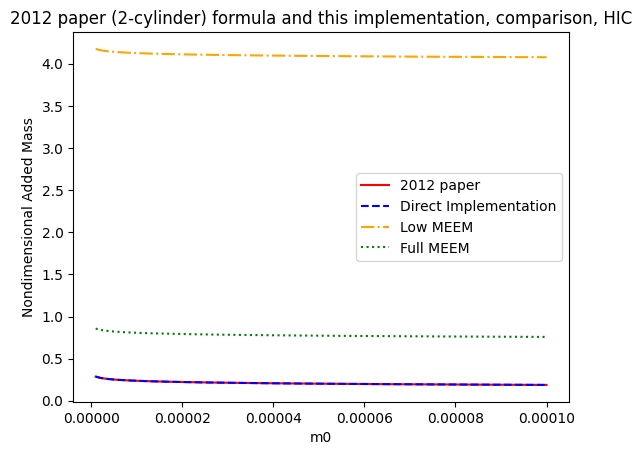

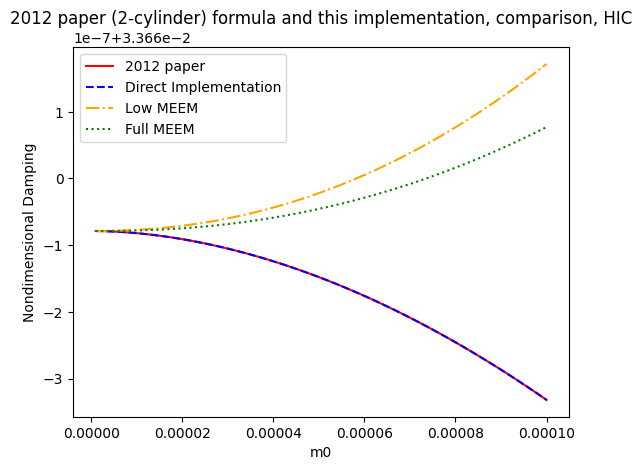

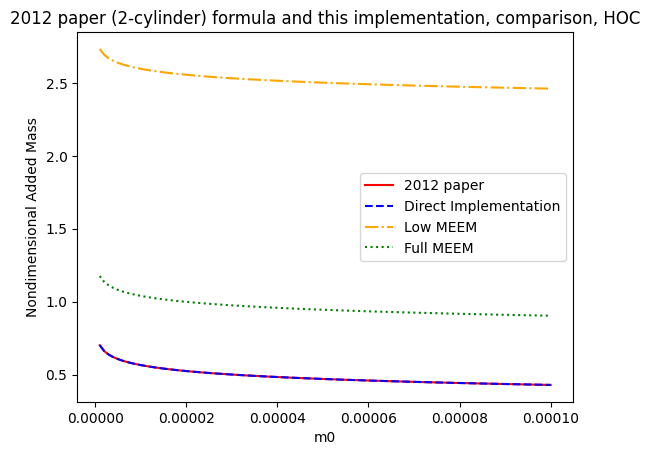

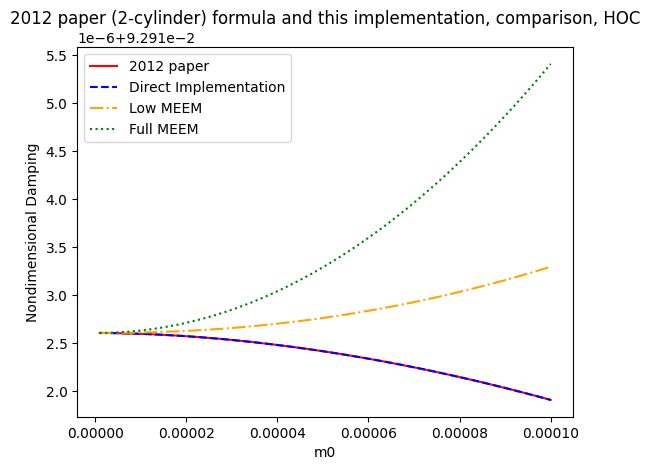

In [26]:
linestyles = ["-", "--", "-.", ":"]
colors = ["red", "blue", "orange", "green"]
labs = ["2012 paper", "Direct Implementation", "Low MEEM", "Full MEEM"]

ys1 = [nondim_am_ic_paper, nondim_am_ic, low_nondim_am_ic, true_nondim_am_ic]
ys2 = [nondim_dp_ic_paper, nondim_dp_ic, low_nondim_dp_ic, true_nondim_dp_ic]
ys3 = [nondim_am_oc_paper, nondim_am_oc, low_nondim_am_oc, true_nondim_am_oc]
ys4 = [nondim_dp_oc_paper, nondim_dp_oc, low_nondim_dp_oc, true_nondim_dp_oc]

plot_compare(m0s, ys1, labs, colors, linestyles, "Nondimensional Added Mass",
             title = "2012 paper (2-cylinder) formula and this implementation, comparison, HIC")

plot_compare(m0s, ys2, labs, colors, linestyles, "Nondimensional Damping",
             title = "2012 paper (2-cylinder) formula and this implementation, comparison, HIC")

plot_compare(m0s, ys3, labs, colors, linestyles, "Nondimensional Added Mass",
             title = "2012 paper (2-cylinder) formula and this implementation, comparison, HOC")

plot_compare(m0s, ys4, labs, colors, linestyles, "Nondimensional Damping",
             title = "2012 paper (2-cylinder) formula and this implementation, comparison, HOC")


In [ ]:
m0 = 1e-6
heaving = [1, 0]
A1 = build_A(h, d, a, m0)
b1 = build_B(h, d, a, heaving)
problem, engine = make_problem_and_engine(h, d, a, heaving, [m0], [1, 1, 1])
A2 = engine.assemble_A_multi(problem, m0)
b2 = engine.assemble_b_multi(problem, m0)

def arr_print(arr):
  print(np.array_str(arr, precision=2))

# Expected to be different, but should be multiples of each other?
arr_print(A1)
arr_print(A2)
arr_print(b1)
arr_print(b2)



[[ 1.00e+00+0.j   -1.00e+00+0.j   -1.10e+00+0.j    0.00e+00+0.j  ]
 [ 0.00e+00+0.j    1.00e+00+0.j    2.30e+00+0.j   -1.00e+00+7.4j ]
 [ 0.00e+00+0.j    0.00e+00+0.j   -2.23e+01+0.j    0.00e+00+0.j  ]
 [ 0.00e+00+0.j    0.00e+00+0.j    6.70e+00+0.j    3.50e-10-4.46j]]
[[ 17.5 +0.j   -17.5 +0.j    21.07+0.j     0.  +0.j  ]
 [  0.  +0.j    33.5 +0.j     0.  +0.j   -67.  +0.j  ]
 [ -0.  +0.j     0.  +0.j    11.17+0.j     0.  +0.j  ]
 [  0.  +0.j     0.  +0.j    -3.35+0.j    -0.59+0.08j]]
[0.06 0.   1.5  0.  ]
[-201.92+0.j   -0.  +0.j   -1.5 +0.j   -0.  +0.j]
